# Runtime Using PID control

### Show again protocol to be followed

<IPython.core.display.Javascript object>


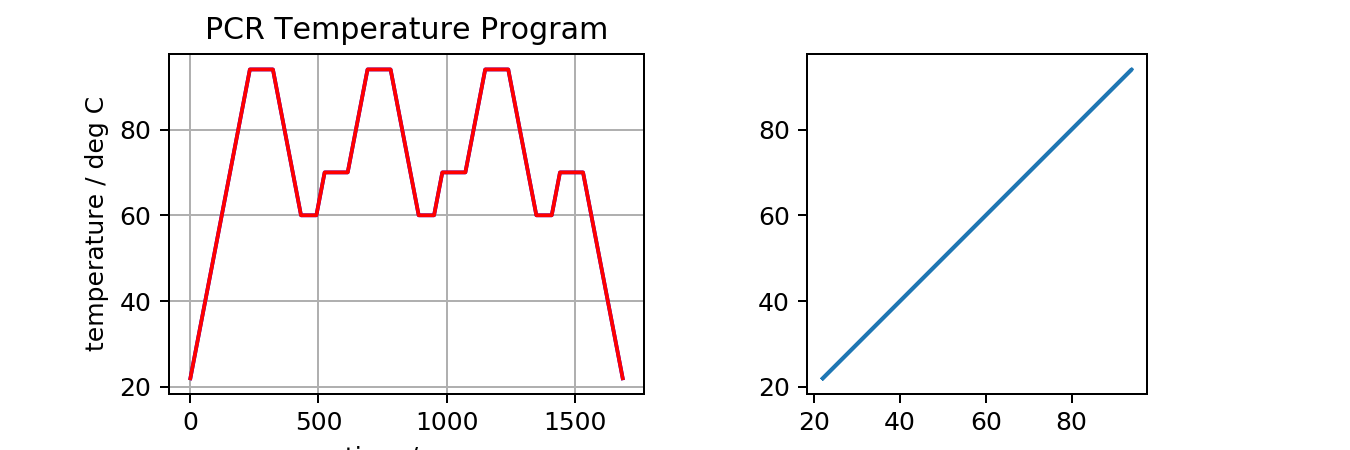

In [52]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

def get_data(file1, file2):
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    ax[0].set_xlabel('time / sec')
    ax[0].set_ylabel('temperature / deg C')
    ax[0].set_title('PCR Temperature Program')
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        u1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        u2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(u1(t), u2(t))
        ax[1].axis('square')
        return t, u1, u2, tmax

t_ref, u1, u2, tmax = get_data('pcr/pcr1.csv', 'pcr/pcr2.csv')

### Control 

In [45]:
conda install -c conda-forge cvxpy 


Note: you may need to restart the kernel to use updated packages.


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: cvxpy


In [46]:
from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy import interpolate
import time

In [47]:
from tclab.gui import NotebookUI
%matplotlib notebook
interface = NotebookUI()

In [49]:
#PID control
class PID:
    def __init__(self):
        self.Kp = 1
        self.Ki = 100
        self.Kd = 0
        self.dt = 1

        self.e = 0
        self.dedt = 0
        self.eint = 0
        self.mv = 0

    def update(self, setpoint, pv):
        e = setpoint - pv
        self.dedt = (self.e - e)/self.dt
        self.eint += e
        self.e = e
        
        self.mv = self.Kp * self.e + self.Ki * self.eint + self.Kd * self.dedt
        return self.mv

### Run Trial

In [51]:
#set setpoints from protocol and heat transfer coefficients for device
SP1 = u1 #setpoint 1
SP2 = u2 #setpoint 2
Ua = 0.021 #heat transfer coefficient heater to ambient
Ub = 0.018 #heat transfer coefficient between heaters
Ta = 22 #ambient temperature in degrees Celsius

from tclab import setup, clock, Historian, Plotter

TCLab = setup(connected=False)

#PID gain coefficients for heater 1
pid1 = PID()
pid1.Kp = 14 #proportional gain
pid1.Ki = 0.04 #integral gain
pid1.Kd = 8 #derivative gain
pid1.dt = 1

#PID gain coefficients for heater 2
pid2 = PID()
pid2.Kp = 14 #proportional gain
pid2.Ki = 0.04 #integral gain
pid2.Kd = 8 #derivative gain
pid2.dt = 1

def work(output, stop):
    with output:
        with TCLab() as lab:
            # setup
            start = time.time()
            lab.P1 = 255
            lab.P2 = 255
            sources = [("T1",lambda:lab.T1),
                       ("T2",lambda:lab.T2),
                       ("SP1",lambda:SP1(t)),
                       ("SP2",lambda:SP2(t)),
                       ("Q1",lambda:lab.Q1()),
                       ("Q2",lambda:lab.Q2()),
                       ]
            layout = [("T1","SP1"), ("T2","SP2"), ("Q1","Q2")]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, len(t_ref),layout=layout)
            
            #commence run
            for t in tclab.clock(len(t_ref)):
                pv1 = lab.T1
                
                pv2 = lab.T2
                mv1 = pid1.update(SP1(t),pv1)
                lab.Q1(mv1)
                mv2 = pid2.update(SP2(t),pv2)
                lab.Q2(mv2)
                p.update(t)
                if stop.value:
                    break
                
            # post-run
            end = time.time()
            fname = datetime.datetime.now().strftime("data/data_%Y%M%dT%H%M%S.csv")
            review_file = datetime.datetime.now().strftime("data/reviewfile.csv")
            h.to_csv(fname)
            h.to_csv(review_file)
            print("Data saved to", fname)
            print("The run took ",end-start,"seconds")

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="danger")
output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '90px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(output_plotter, stop))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="danger"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
    plt.close()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
display(output_plotter)

Output(layout=Layout(border='1px solid black', height='90px'))

Output(layout=Layout(border='1px solid black', height='500px'))